# NoteBook tutorial de Deep Learning; Redes Fully Conected

### Alcance

El alcance de este notebook es el de mostrar la teoria detras de las arquitecturas de redes neuronales Fully Conected, así como el de mostrar paso a paso como resolver un problema de identificación de digitos sencillo usando PyTorch.



## Introducción

El deep learning es la disciplina de la inteligencía artificial que aprende automaticamente las caracterisitcas de un DataSet directamente de la data a distintos niveles de abstracción.

En terminos de eficiencia es similar al del Machine Learning tradicional, si se abarca la misma cantidad de datos que este ultimo usa. Sin embargo al enfrentarse a problemas con máyor nivel de abstracción y manejo de datos el deep learning es superior, por esta razón es usado para analisis de imagen, texto, video y audio.

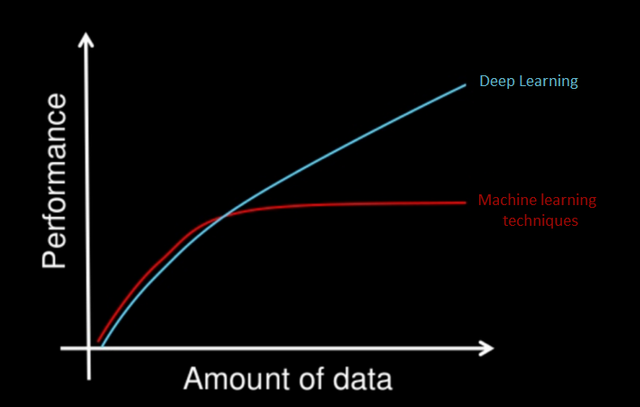

Cuando se habla de máyor nivel de abstracción es dificil indicar un valor en sí, pero una heuristica es que se maneja alrededor de datos de un millon o más.

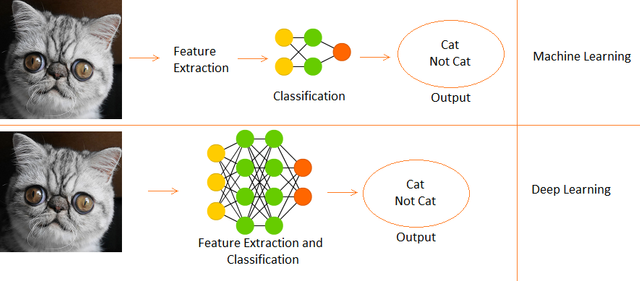

Imagenes tomadas de Deep Learning Tutorial for beginners | Kaggle

Para este Tutorial, se trabajar con el dataset MNIST - Digit

### Importando las librerias que se utilizaran.

In [0]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim

In [0]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%cd '/content/gdrive/My Drive/MNIST/train'

/content/gdrive/My Drive/MNIST/train


Como en todo problema de ML, DL. El primer paso es entender la naturaleza del problema y su relación con la data. Para el caso del DataSet MNIST - Digit, consta de un archivo en csv, donde la primera columna guarda la información de tipo de digito es: un numero del 0 al 9, mientras que las otras 784 columnas guardan la información de cada pixel, para una imagen de 28x28 de un solo canal. La información del csv es de tipo int.

Las redes neuronales de PyTorch no funcionan bien con datos integer, es una buena practica convertirlos a float32.

In [0]:
train = pd.read_csv('train.csv', dtype = np.float32)

In [0]:
%cd '/content/gdrive/My Drive/MNIST/test'

/content/gdrive/My Drive/MNIST/test


In [0]:
test = pd.read_csv('test.csv', dtype = np.float32)

In [0]:
target = train['label'].values

In [0]:
train.drop('label', axis=1, inplace=True)

### Preparando la data

Es una buena practica en DL, separar la data de entrada en dos sets uno de entrenamiento y otro de validación, esto con el proposito de evaluar la arquitectura de la red neuronal y hacer los ajustes nesesarios para evitar que esta se sobreajuste.

Para este caso se puede usar la función de SciKit Learn train_test_split, la data se puede separar, 90% entrenamiento, 10% validación o 80% entrenamiento, 20% validación. Para este caso se usara 80-20.

Por otra parte las redes nuronales trabajan mejor con datos normalizados, acotados en rangos pequeños. Los más comunes son de 0 a 1, -1 a 1 o -3 a 3. Para este caso se reducira de 0 a 1, diviendo por 255.

In [0]:
train = train.loc[:].values / 255.0
test = test.loc[:].values / 255.0

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(train, target, test_size = 0.2, random_state = 0)

In [0]:
X_train.shape

(33600, 784)

In [0]:
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train).type(torch.LongTensor)

X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test).type(torch.LongTensor)

In [0]:
X_train.shape

torch.Size([33600, 784])

### Cargando la data a la red neuronal

Las redes neuronales, aunque potentes, son algoritmos que representan un alto costo computacional. Es muy contraproducente cargar todo el dataset a una red, para esto se define el objeto DataLoader, este carga por batches aleatorios la información a la red neuronal, aumentar el batch mejora sus resultados pero incrementa el tiempo de computo.

In [0]:
train = TensorDataset(X_train, Y_train)
val = TensorDataset(X_test, Y_test) 

In [ ]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)
val_loader = DataLoader(val, batch_size=128, shuffle=True)

### Entendiendo las redes neuronales

Antes de analizar la arquitectura para este DataSet, vamos a hacer un repaso general detras de la teoria de grafos.

#### Grafos

Los grafos son estrucutaras dinamicas con una relación no líneal que permiten representar relaciones binarias entre elementos de un conjunto, sin embargo esta explicación es un poco vaga. Para mí son una excelente herramienta en computación para representar graficamente expresiones matematicas.

Por ejemplo la expresión:

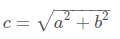

Se puede expresar con el siguiente grafo:

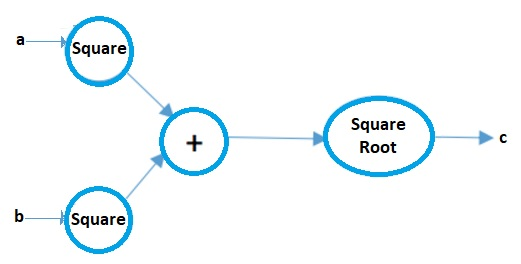

Las redes neuronales multiples se apoyan fuertemente en la regresión lineal multiple. Como ejemplo usando el dataset SIGNS de clase, el grafo para expresar la operación matematica de si una imagen es la representación de uno o no sería este:

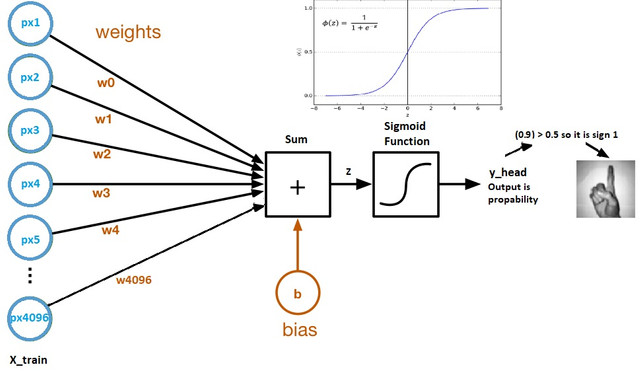

Donde la capa de entrada está compuesta del valor numerico de cada pixel y cada uno tiene asignado un peso. Volviendo a nuestro ejercicio, recordemos que las 784 columnas de cada DataSet contienen la información de cada pixel, esto nos lleva a concluir dos cosas:

1. La capa de entrada es un tensor de una sola dimensión, usualmente un tensor largo donde se encuentra de forma secuencial la información a procesar, en el caso de las imagenes, la información de cada pixel.
2. Ya los datasets, están listos para ser procesados por una red neuronal.

#### La red neuronal

Las redes neuronales artificiales o redes fully connected emulan el funcionamiento de las redes neuronas humanas. La neurona tiene un grupo de señales de entrada y una sola salida.

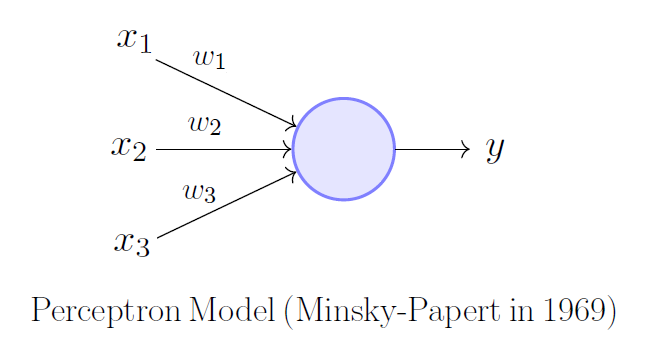

A este grafo se le conoce como perceptron. Sin embargo así como una neurona no es un cerebro humano, un perceptron por si solo no es una red neuronal artificial.

#### Capas ocultas

Volviendo al ejemplo del dataset Signs, surge la duda ¿Qué estoy detectando con mi grafo original? la respuesta sería caracteristicas, sin embargo son caracteristicas básicas, los contornos de la imagen para ser exactos. Estas formas por si solas solo me dan una probabilidad del 50% de dicernir si la imagen es un uno o no, un resultado mediocre, es acá donde nos volvemos a apoyar en la naturaleza para mejorar nuestro resultado. 

Existe un concepto en el mundo natural llamado emergencia, cuando organismos simples se agrupan de forma organizada para asegurar su supervivencia, esto se puede observar en una colina de hormigas, una hormiga por si sola, es debil, una colina de hormigas puede realizar estructuras subterraneas complejas para garantizar su supervivencia. 

Así que si entre mi capa de entrada y salida inserto una capa adicional que me perimita detectar formas más complejas podria no solo detectar los contornos sino también formas convexas y caracterisitcas unicas como el dedo gordo de la mano.

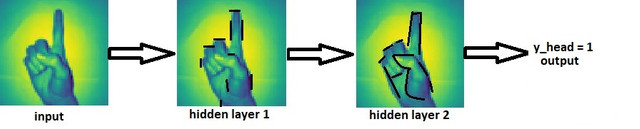

A esta capa se le conoce como capa oculta, se dice que es oculta porque sus valores de entrada no son los inputs obtenidos del dataset, son ocultos tanto para el usuario como para el programador.

Ahora, si recordamos el principio detras de las redes neuronales su esqueleto es el de una regresión lineal multiple, así mismo no serviria incluir una capa oculta entre la entrada y la salida simplemente, estas colapsarian en un perceptron gigante, que no nos aportaria nada. Se hace nesesario incluir una función de activación entre la capa oculta y la capa de salida para que distorsione la naturaleza lineal entre las capas y nos permita obtener la extracción de caracteristicas que nesecitamos.

Este seria el grafo de una red con dos perceptrones:

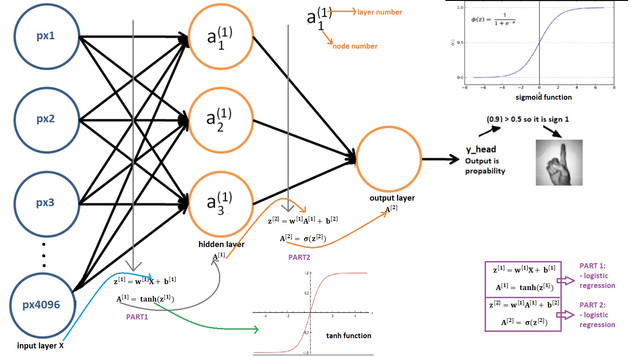

Ahora recordemos, que cada input o neurona tiene asociado un peso, no sería util y en realidad seria bastante tedioso asignar manualmente el peso de cada uno. Es acá donde entra el concepto de inteligencia artificial, es más util que sea el computador el que decida que peso debe tener cada neurona. 

#### Backpropagation

Esto es posible con el algoritmo de BackPropagation. Este algoritmo es la base del exito de las redes neuronales. Este evalua de acuerdo al resultado final de la red capa por capa cual es el peso adecuado que debe tener cada neurona. Este proceso es iterativo a mayores iteraciones, mejores resultados. Un recorrido por el dataset se conoce como epoca(epoch).

Bajo este escenario se puede categorizar a las redes neuronales como algoritmos de aprendizaje supervizados.

Es importante recordar acá los conceptos de sobreajuste(overfitting) y subajuste(underfitting), existen varias formas de monitorear el desempeño de una red en relación a estos dos conceptos, la mejor forma es visual.

Aprendizaje con sobreajuste:

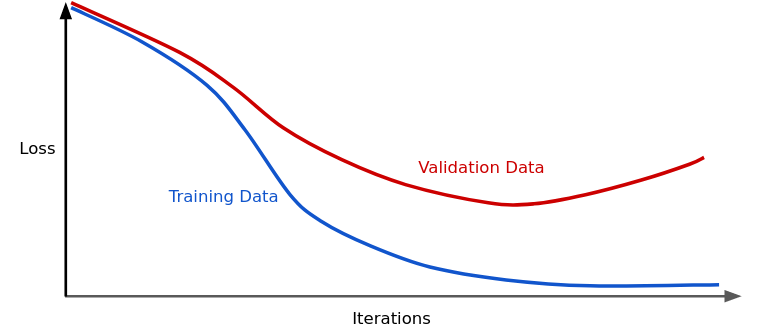

Aprendizaje con subajuste:

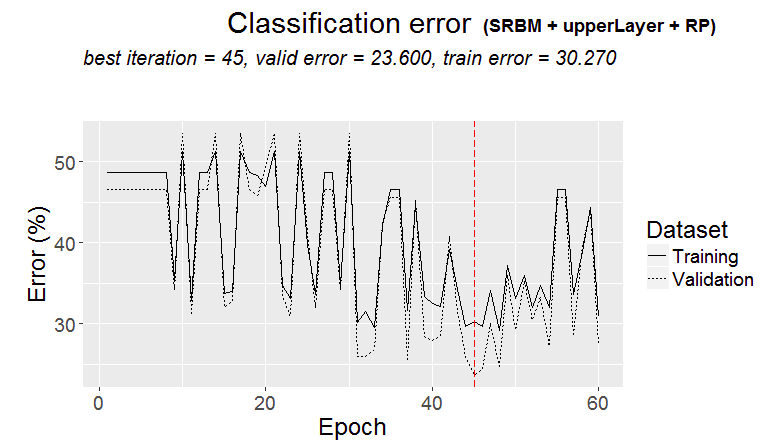

Aprendizaje optimo:

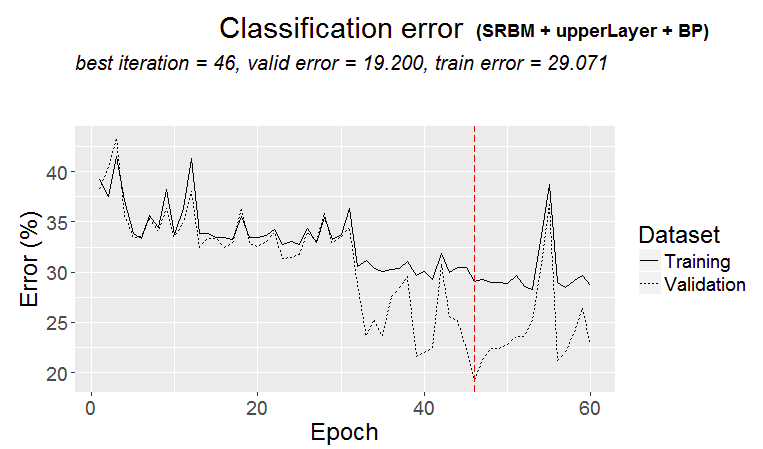

Es importante definir las epocas suficientes para que un modelo se entrene, un valor comun para empezar es 100 epochs.

En caso de que un modelo presente subajuste se recomienda:

* Aumentar la cantidad de capas.
* Agregar más neuronas por capa.
* Aumentar el numero de epocas
* Eligir un metodo de optimización más complejo

En casode que un modelo presente sobreajuste se recomienda:

* Entrenar con más datos
* Utilizar técnicas de regularización.

En base a esta definición se nesecita entonces definir una función matematica que evalue el error de de la red y un optimizador que minimice el error de esta. O dicho de otra forma que determine los parametros en los que la función de error sea mínima.

#### Optimizadores y funciones de perdida o coste

El optimizador más comun es SGD (Stochastic Gradient Descent).

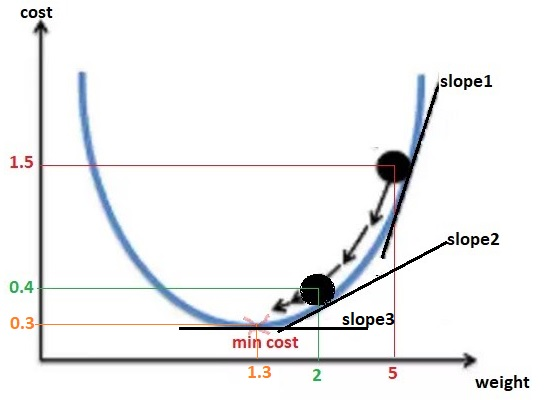

No obstante existen varios optimizadores, siendo el favorito de la comunidad Adam, que combina los principios matematicos de Momentum y AdaBoost.

En estos links de youtube hay más información sobre cada uno:

Adaboost
https://www.youtube.com/watch?v=LsK-xG1cLYA

Momentum
https://www.youtube.com/watch?v=6iwvtzXZ4Mo

La información hasta al momento nos lleva a concluir dos conceptos adicionales:

1. Se debe definir la función matematica adecuada para determinar el error de la red neuronal
2. Se debe definir las funciones de activación de las capas ocultas y la capa final para evitar que la red neuronal colapse en un perceptron gigante.

La función que determina el error de la red se conoce como función de perdidad. Esta y las funciones de activación están muy relacionadas a la naturaleza del problema, según la experiencia general de la comunidad los problemas más comunes y sus funciones son:

* Problemas de regressión simple: Para este caso la ultima capa tiene una neurona, no se hace nesesario definir una función de activación final, la función de activación intermedia es ReLU y su función de perdida es el error cuadratico promedio.
* Problemas de clasificación binaria: La ultima capa tiene una neurona, la función de activación final es sigmoide o log_sigmoide, la función de activación intermedia es ReLU o Tanh y su función de perdida es entropia cruzada binaria. Se puede usar entropia cruzada pero cambiando la ultima capa a dos valores y sustrayendo la función de activación sigmoide.
* Problemas de clasificación multiclase una sola label(etiqueta): El numero de neuronas en la capa de salida es igual la numero de clases a clasificar, la función de activación final es softmax o log-softmax, la función de activación intermedia es ReLU o Tanh y su función de perdida final es NLL(Negative log-likelihood) o entropia cruzada.
* Problemas de clasificación multiclase y multilabel(varias etiquetas): El numero de neuronas en la capa de salida es igual la numero de clases a clasificar, la función de activación final es sigmoide o log-sigmoide, la función de activación intermedia es ReLU o Tanh y su función de perdida final es entropia cruzada bianaria.

#### Hiperparametros

En este punto podemos inferir que existen parametros nesesarios para la correcta operación de una red neuronal, pero que no existe una forma presisa de definirlos, su selección se determina más por prueba y error, estos son en orden de importancía:

* Learning rate
* Optimizador
* Mini-batch-size
* Cantidad de neuronas en capas ocultas
* Cantidad de capas ocultas

Como técnicas de definición de hiperparametros están:

* Forma manual
* Forma aleatoria
* Metodos Bayesianos

La más usada es la forma aleatoria y por hiperparametro, los metodos manuales son engorrosos y los metodos bayesianos, son computacionalmente costosos; aunque potentes.

-------------

Una vez aclarados los conceptos de las redes neuronales, podemos definir la arquitectura de nuestro dataset MNIST.

Es una buena practica redondear el numero de neuronas de entrada a la potencia de dos más cercana, para el caso del total de pixeles 784, lo redondeamos a 2084; 2e11.

Definimos entonces la siguiente arquitectura:

* Una capa de entrada de 784 a 2084.
* Cuatro capas ocultas(2084 a 1024, 1024 a 512, 512 a 256, 256 a 128)
* Una capa de salida de 10
* Función de activación intermedia ReLU
* Función de activación final Log-Softmax.
* Función de perdida NLLLoss
* Batch-size de 128
* Técnica de regularización BatchNorm y Dropout.
* Optimizador SGD
* Numero de epocas 150

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.fc1 = nn.Linear(784, 2048)
    self.fcbn1 = nn.BatchNorm1d(2048)
    self.fc2 = nn.Linear(2084, 1024)
    self.fcbn2 = nn.BatchNorm1d(1024)
    self.fc3 = nn.Linear(1024, 512)
    self.fcbn3 = nn.BatchNorm1d(512)
    self.fc4 = nn.Linear(512, 256)
    self.fcbn4 = nn.BatchNorm1d(256)
    self.fc5 = nn.Linear(256, 128)
    self.fcbn5 = nn.BatchNorm1d(128)
    self.fc6 = nn.Linear(128, 10)

  def forward(self, x):
    #fc
    x = F.relu(self.fcbn1(self.fc1(x)))
    x = F.dropout(x, p = 0.8, training=True)
    x = F.relu(self.fcbn2(self.fc2(x)))
    x = F.dropout(x, p = 0.8, training=True)
    x = F.relu(self.fcbn3(self.fc3(x)))
    x = F.dropout(x, p = 0.8, training=True)
    x = F.relu(self.fcbn4(self.fc4(x)))
    x = F.dropout(x, p = 0.8, training=True)
    x = F.relu(self.fcbn5(self.fc5(x)))
    x = F.dropout(x, p = 0.8, training=True)
    x = self.fc6(x)

    #log softmax
    x = F.log_softmax(x, dim=1)

    return x




In [0]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0
  
  def update(self, val, size):
    self.S += val
    self.N += size

  def __call__(self):
    return self.S/float(self.N)


In [0]:
device = torch.device('cuda')

In [0]:
net = Net().to(device)

In [0]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0019, momentum=0.9)

In [0]:
num_epoch = 150

In [0]:
for epoch in range(num_epoch):
  print('Epoch: {}/{}'.format(epoch+1, num_epoch))
  print('-'*64)

  running_loss = RunningMetric()
  running_acc = RunningMetric()

  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)

    loss = loss_fn(outputs, targets)

    loss.backward()
    optimizer.step()

    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size, batch_size)
    running_acc.update(torch.sum(preds==targets).float(), batch_size)

  print('Loss: {:.4f}, Acc: {:.4f}'.format(running_loss(), running_acc()))

Epoch: 1/150
----------------------------------------------------------------
Loss: 2.4457, Acc: 0.1103
Epoch: 2/150
----------------------------------------------------------------
Loss: 2.2480, Acc: 0.1642
Epoch: 3/150
----------------------------------------------------------------
Loss: 2.0491, Acc: 0.2324
Epoch: 4/150
----------------------------------------------------------------
Loss: 1.9085, Acc: 0.2514
Epoch: 5/150
----------------------------------------------------------------
Loss: 1.8284, Acc: 0.2589
Epoch: 6/150
----------------------------------------------------------------
Loss: 1.7785, Acc: 0.2729
Epoch: 7/150
----------------------------------------------------------------
Loss: 1.7475, Acc: 0.2774
Epoch: 8/150
----------------------------------------------------------------
Loss: 1.7233, Acc: 0.2830
Epoch: 9/150
----------------------------------------------------------------
Loss: 1.7029, Acc: 0.2914
Epoch: 10/150
--------------------------------------------------

In [0]:
datalaoders = {'train': train_loader,
               'val': val_loader}

In [0]:
def train_and_evaluate(model, optimizer, loss_fn, dataloaders, device, num_epoch=10, lr=0.0019):
  for g in optimizer.param_groups:
    g['lr'] = lr

  for epoch in range(num_epoch):
    print('Epoch {}/{}'.format(epoch+1, num_epoch))
    print('-'*64)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = RunningMetric()
      running_acc = RunningMetric()

      for inputs, targets in dataloaders[phase]:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = net(inputs)
          _, preds = torch.max(outputs, 1)

          loss = loss_fn(outputs, targets)
          
          if phase == 'train':
            loss.backward()
            optimizer.step()

        batch_size = inputs.size()[0]
        running_loss.update(loss.item()*batch_size,
                            batch_size)
        running_acc.update(torch.sum(preds==targets).float(), batch_size)
      
      print('Loss: {:.4f}, Acc: {:.4f}'.format(running_loss(), running_acc()))

In [0]:
train_and_evaluate(net, optimizer, loss_fn, datalaoders, device)

Epoch 1/10
----------------------------------------------------------------
Loss: 0.3529, Acc: 0.9090
Loss: 0.4062, Acc: 0.9012
Epoch 2/10
----------------------------------------------------------------
Loss: 0.3600, Acc: 0.9079
Loss: 0.4147, Acc: 0.9048
Epoch 3/10
----------------------------------------------------------------
Loss: 0.3484, Acc: 0.9099
Loss: 0.4152, Acc: 0.9064
Epoch 4/10
----------------------------------------------------------------
Loss: 0.3540, Acc: 0.9089
Loss: 0.4158, Acc: 0.9064
Epoch 5/10
----------------------------------------------------------------
Loss: 0.3520, Acc: 0.9096
Loss: 0.4281, Acc: 0.8998
Epoch 6/10
----------------------------------------------------------------
Loss: 0.3513, Acc: 0.9099
Loss: 0.3945, Acc: 0.9027
Epoch 7/10
----------------------------------------------------------------
Loss: 0.3445, Acc: 0.9125
Loss: 0.3876, Acc: 0.9045
Epoch 8/10
----------------------------------------------------------------
Loss: 0.3458, Acc: 0.9135
Lo

In [0]:
torch_test = torch.from_numpy(test)
temp = np.zeros(test.shape)
temp = torch.from_numpy(temp)
test_set = TensorDataset(torch_test, temp)

test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

submission = [['ImageID', 'Label']]

with torch.no_grad():
  net.eval()
  image_id = 1

  for inputs, _ in test_loader:
     inputs, _ = inputs.to(device), _.to(device)
     output = net(inputs)
     res = torch.exp(output)
     top_p, top_class = res.topk(1, dim = 1)

     for prediction in top_class:
       submission.append([image_id, prediction.item()])
       image_id += 1



In [0]:
submission

[['ImageID', 'Label'],
 [1, 2],
 [2, 0],
 [3, 9],
 [4, 9],
 [5, 3],
 [6, 7],
 [7, 0],
 [8, 3],
 [9, 0],
 [10, 3],
 [11, 5],
 [12, 7],
 [13, 4],
 [14, 0],
 [15, 4],
 [16, 3],
 [17, 3],
 [18, 1],
 [19, 9],
 [20, 0],
 [21, 9],
 [22, 1],
 [23, 1],
 [24, 5],
 [25, 7],
 [26, 9],
 [27, 2],
 [28, 7],
 [29, 9],
 [30, 7],
 [31, 7],
 [32, 5],
 [33, 4],
 [34, 2],
 [35, 6],
 [36, 2],
 [37, 5],
 [38, 5],
 [39, 1],
 [40, 6],
 [41, 7],
 [42, 7],
 [43, 4],
 [44, 9],
 [45, 8],
 [46, 7],
 [47, 8],
 [48, 2],
 [49, 6],
 [50, 1],
 [51, 6],
 [52, 8],
 [53, 1],
 [54, 3],
 [55, 8],
 [56, 2],
 [57, 1],
 [58, 2],
 [59, 2],
 [60, 0],
 [61, 4],
 [62, 1],
 [63, 7],
 [64, 0],
 [65, 0],
 [66, 0],
 [67, 1],
 [68, 9],
 [69, 0],
 [70, 1],
 [71, 6],
 [72, 5],
 [73, 8],
 [74, 8],
 [75, 2],
 [76, 8],
 [77, 3],
 [78, 9],
 [79, 2],
 [80, 3],
 [81, 5],
 [82, 9],
 [83, 1],
 [84, 0],
 [85, 9],
 [86, 2],
 [87, 4],
 [88, 3],
 [89, 6],
 [90, 7],
 [91, 2],
 [92, 0],
 [93, 6],
 [94, 6],
 [95, 1],
 [96, 4],
 [97, 3],
 [98, 9],
 [99, 

In [0]:
test_display = test.reshape(-1, 28, 28, 1)


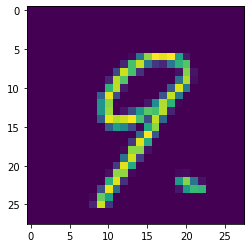

In [0]:
for i in range(3):
  plt.imshow(test_display[i][:, :, 0])

In [0]:
sub = pd.DataFrame(submission)
sub.columns = sub.iloc[0]
sub.drop(0, axis=0, inplace=True)
sub

,ImageID,Label
1,1,2
2,2,0
3,3,9
4,4,9
5,5,3
...,...,...
27996,27996,9
27997,27997,7
27998,27998,3
27999,27999,9
